In [36]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing, metrics
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.inspection import permutation_importance
from datetime import date

In [37]:
# extract data
start_date = '2024-01-01' 
split_date = '2024-06-30'
end_date = '2024-07-31'
tickers = ['AAPL','MSFT','NVDA','GOOG','AMZN','META','TSM','LLY','TSLA','AVGO']

data = {}
for ticker in tickers:
    data[ticker] = yf.download(ticker, start=start_date, end=end_date)

y_variable = 'Y2' # Y1: next day, Y2: next n days
n = 1

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [38]:
# define indicators

def std(data):
    #data['sd_y'] = data['Close'].rolling(252).std()
    data['sd_m'] = data['Close'].rolling(21).std()
    data['sd_w'] = data['Close'].rolling(5).std()

def bollinger_strat(data, window, no_of_std):
    rolling_mean = data['Close'].rolling(window).mean()
    rolling_std = data['Close'].rolling(window).std()

    data['boll_high'] = rolling_mean + (rolling_std * no_of_std)
    data['boll_low'] = rolling_mean - (rolling_std * no_of_std)     

def heikin_ashi(data):
    data['open_HA'] = (data['Open'].shift(1) + data['Close'].shift(1))/2
    data['close_HA'] = (data['open_HA']+data['Close']+data['High']+data['Low'])/4

def stochastic_oscillator(data, n, m):
    high_n = data['High'].rolling(window=n).max()
    low_n = data['Low'].rolling(window=n).min()
    data['k'] = ((data['Close'] - low_n) / (high_n - low_n)) * 100
    data['d'] = data['k'].rolling(window=m).mean()
    data['sto_oscil'] = data['k'] - data['d']
    data.drop(columns=['k', 'd'], inplace=True)
    #return k, d

def bears_bulls_power(data, ma_window):
    ma = data['Close'].rolling(window=ma_window).mean()
    data['bull_power'] = data['High'] - ma
    data['bear_power'] = data['Low'] - ma
    #return bears_power, bulls_power

def rsi(data, window):
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    data['rsi'] = 100 - (100 / (1 + rs))
    #return rsi

def logret(data):
    data['return'] = np.log(1+ data['Close'].pct_change())
    data['ret_bin'] = np.where(data['return'] >= data['return'].median(), 1,0) # median works better for returns and trading
    data['Y1'] = data['ret_bin'].shift(-1)
    data['Y2'] = np.where(data['return'].rolling(n).sum() >= data['return'].median(), 1,0)
    data['Y2'] = data['Y2'].shift(-(n))
    #return data

def mom(data, window):
    data['mom'] = data['Close'].rolling(window).apply(np.sum)

def obv(data):
    data['obv1'] = np.where(data['Close'] >= data['Close'].shift(-1),1,-1)*data['Volume']
    data['obv'] = data['obv1'].cumsum()
    data.drop(columns=['obv1'], inplace=True)

def accum_distribute(data):
    data['ad1'] = data['Volume']*(2*data['Close']-data['Low']-data['High'])/(data['High']-data['Low'])
    data['acc_dis'] = data['ad1'].cumsum()
    data.drop(columns=['ad1'], inplace=True)

def aroon(data, window):
    data['up'] = 100 * data.High.rolling(window).apply(lambda x: x.argmax()) / window
    data['dn'] = 100 * data.Low.rolling(window).apply(lambda x: x.argmin()) / window
    data['aroon'] = data['up'] - data['dn'] 

def atr(data, window):
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift())
    low_close = np.abs(data['Low'] - data['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    data['atr'] = true_range.rolling(window).sum()/window


In [39]:
# calculate indicators
import pandas_ta as ta

def calculate(data):
    std(data)
    bollinger_strat(data, 10, 2)
    heikin_ashi(data)
    stochastic_oscillator(data, 10, 3)
    bears_bulls_power(data, 10)
    rsi(data, 10)
    logret(data)
    mom(data, 10)
    obv(data)
    accum_distribute(data)
#    aroon(data, 15)
#    atr(data, 10)

for ticker in tickers:
    calculate(data[ticker])
    adx = ta.adx(data[ticker]['High'], data[ticker]['Low'], data[ticker]['Close'], length = 14)
    data[ticker] = data[ticker].join(adx)

In [40]:
# train/test split
def train_test_split_by_date(data, split_date, name):
    # set date as index
    #data['date'] = pd.to_datetime(data['date'])
    data.reset_index(inplace=True)

    # Split the DataFrame into training and testing sets
    x = data[data['Date'] <= split_date].sort_values('Date')
    y = data[data['Date'] <= split_date].sort_values('Date')[y_variable]
    test = data[data['Date'] > split_date].sort_values('Date')

    # Store the sets in a dictionary with their names
    sets = {
        f'{name}train_x': x,
        f'{name}train_y': y,
        f'{name}test': test
    }

    return sets

df_split = {}
for ticker in tickers:
    df_split[ticker] = train_test_split_by_date(data[ticker].dropna(), split_date, '')

In [41]:
# cross validation for time series data
from sklearn.model_selection import TimeSeriesSplit

n_fold = 3 

folds = TimeSeriesSplit(
    n_splits=n_fold,
    gap=0, # gap between the train and test side of the splits. 
    max_train_size=10000, 
    test_size=10, # about 10% of training data
)

# specify columns used for model inputs
columns = ['High','Low','Close','Volume','sd_m','sd_w','boll_high','boll_low','open_HA','close_HA','sto_oscil',
           'bull_power','bear_power','rsi','return','ret_bin','mom','obv','acc_dis','ADX_14','DMP_14','DMN_14',
           #'aroon','atr',
           #'3mt','5yt','spread'
          ]

In [42]:
# model for time series CV
import math
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, r2_score

params = {"boosting_type": "gbdt", "metric": 'binary_logloss', "verbosity": -1, 'random_state': 13}

num_iteration = {}
X_valid = {}
feature_importances = {}
classifiers = {}
df_predicted = {}
for ticker in tickers:
    splits = folds.split(df_split[ticker]['train_x'], df_split[ticker]['train_y'])
    y_preds = np.zeros(df_split[ticker]['test'].shape[0])
    y_oof = np.zeros(df_split[ticker]['train_x'].shape[0])
    feature_importances[ticker] = pd.DataFrame()
    feature_importances[ticker]['feature'] = columns
    for fold_n, (train_index, valid_index) in enumerate(splits):
        print('Fold:',fold_n+1)
        X_train, X_valid[ticker] = df_split[ticker]['train_x'][columns].iloc[train_index], df_split[ticker]['train_x'][columns].iloc[valid_index]
        y_train, y_valid = df_split[ticker]['train_y'].iloc[train_index], df_split[ticker]['train_y'].iloc[valid_index]
        dtrain = lgb.Dataset(X_train, label=y_train)
        dvalid = lgb.Dataset(X_valid[ticker], label=y_valid)
        clf = lgb.train(params, dtrain, 50, valid_sets = [dtrain, dvalid])
        classifiers[ticker] = clf
        num_iteration[ticker]=clf.best_iteration
#        feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
        y_pred_valid = clf.predict(X_valid[ticker],num_iteration=clf.best_iteration)
        y_oof[valid_index] = y_pred_valid
        y_preds += clf.predict(df_split[ticker]['test'][columns], num_iteration=num_iteration[ticker])/n_fold
    df_split[ticker]['test']['predicted'] = y_preds
    df_split[ticker]['test']['binary'] = np.where(y_preds >= 0.5, 1,0)
    df_predicted[ticker] = df_split[ticker]['test'][['Date','return',y_variable,'predicted','binary']]
    
    # calculate insample results to estimate overfitting
#    Y_preds = np.zeros(df_split[ticker]['train_x'].shape[0])
#    Y_preds += clf.predict(df_split[ticker]['train_x'][columns], num_iteration=clf.best_iteration)
#    df_split[ticker]['train_x']['predicted'] = np.where(Y_preds >= 0.5, 1,0)
#    insample = df_split[ticker]['train_x'][['Date',y_variable,'predicted']]

#    print('insample ROC AUC is: ',roc_auc_score(insample[y_variable],insample['predicted']))
#    print('insample PR AUC is: ',average_precision_score(insample[y_variable],insample['predicted']))    
#    print('ROC AUC score is: ',roc_auc_score(df_predicted[y_variable],df_predicted['predicted']))
#    print('PR AUC score is: ',average_precision_score(df_predicted[y_variable],df_predicted['predicted']))
    
    # print classification metrics report
    print(metrics.classification_report(df_predicted[ticker][y_variable],df_predicted[ticker]['binary']))

Fold: 1
Fold: 2
Fold: 3
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         8
         1.0       0.60      1.00      0.75        12

    accuracy                           0.60        20
   macro avg       0.30      0.50      0.38        20
weighted avg       0.36      0.60      0.45        20

Fold: 1
Fold: 2
Fold: 3
              precision    recall  f1-score   support

         0.0       0.50      0.50      0.50        12
         1.0       0.25      0.25      0.25         8

    accuracy                           0.40        20
   macro avg       0.38      0.38      0.38        20
weighted avg       0.40      0.40      0.40        20

Fold: 1
Fold: 2
Fold: 3
              precision    recall  f1-score   support

         0.0       0.33      0.17      0.22        12
         1.0       0.29      0.50      0.36         8

    accuracy                           0.30        20
   macro avg       0.31      0.33      0.29        20
we

In [ ]:
# importance scores from shap
import shap

for ticker in tickers:
    shap_values = shap.TreeExplainer(classifiers[ticker]).shap_values(X_valid[ticker])
    shap.summary_plot(shap_values, X_valid[ticker], plot_type="bar")

-0.058376365231353915
-0.05230511987931147


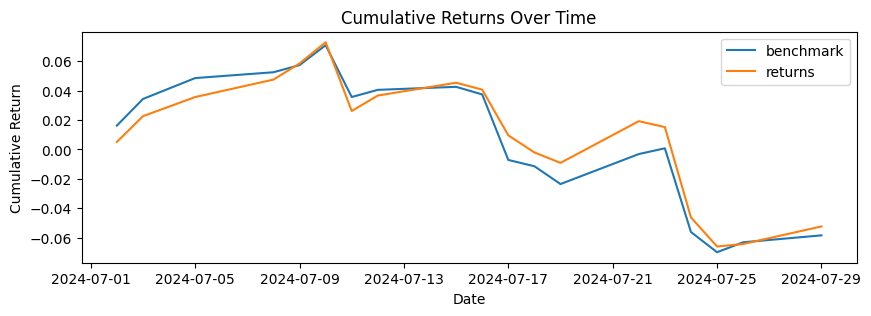

In [44]:
# flatten dataframe
t = []
for ticker in tickers:
    for date in df_predicted[ticker]['Date'].unique():
        x = df_predicted[ticker][df_predicted[ticker]['Date'] == date]
        x['ticker'] = ticker
        t.append(x)
t = pd.concat(t)

t.to_csv('C:\\Users\\dawei\\Dropbox\\NUS\\DSA5205\\project\\LGBM.csv')

# choose top n predicted stocks each day
n = 5
t['top'] = t.groupby('Date')['predicted'].rank(method='first', ascending=False) <= n
t['top'] = t['top'].astype(int)

# calculate returns
x = []
for ticker in t['ticker'].unique():
    tt = t[t['ticker'] == ticker]
    tt['strat'] = tt['return']*tt['top'].shift(1)
    x.append(tt)
x = pd.concat(x)
x = x.dropna()

tt = []
for date in x['Date'].unique():
    t = x[x['Date'] == date]
    trade = t['strat'].sum()/n
    ret = t['return'].mean()
    tt.append(pd.DataFrame({'date': [date], 'return': [ret], 'trade': [trade],}))
tt = pd.concat(tt)

print(tt['return'].sum())
print(tt['trade'].sum())
tt['date'] = pd.to_datetime(tt['date'])
plt.figure(figsize=(10, 3))
plt.plot(tt['date'], tt['return'].cumsum(), label='benchmark')
plt.plot(tt['date'], tt['trade'].cumsum(), label='returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(False)
plt.show()

In [45]:
# next trade
t = []
for ticker in tickers:
    t.append(pd.DataFrame({'ticker': [ticker], 
                           'predicted': [classifiers[ticker].predict(data[ticker].iloc[-1][columns], num_iteration=num_iteration[ticker])]
                           }))
t = pd.concat(t)
t['predicted'] = t['predicted'].astype(str)
t['top'] = t['predicted'].rank(method='first', ascending=False) <= n
t['top'] = t['top'].astype(int)
t

,ticker,predicted,top
0,AAPL,[0.72052371],1
0,MSFT,[0.52125416],0
0,NVDA,[0.66239069],0
0,GOOG,[0.89870952],1
0,AMZN,[0.6984858],0
0,META,[0.97286442],1
0,TSM,[0.31072285],0
0,LLY,[0.81421711],1
0,TSLA,[0.89039905],1
0,AVGO,[0.34764349],0


In [46]:
import gc
gc.collect()

42320